## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [393]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [160]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_boxplot

In [394]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [669]:
data_set = pd.read_feather("/home/alvaro/data/financials_against_return.feather")

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [670]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [623]:
data_set.shape

(170483, 145)

Filter stocks to only the top 1000 in terms of marketcap as of the last date in the data, in order to agilize the training of the model.

In [671]:
data_set.execution_date.tail(1)

170482   2021-03-27
Name: execution_date, dtype: datetime64[ns]

In [672]:
top_tickers_mcap = data_set[data_set.execution_date == '2021-03-27'].sort_values('Market_cap', ascending=False).Ticker.head(1000)
data_set = data_set[data_set.Ticker.isin(top_tickers_mcap.values)]

Create the target:

In [673]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
1.0    27490
0.0    21391
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [483]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [402]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [674]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
   
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [404]:
import warnings
import shap
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300, learning_rate = 0.1):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             'learning_rate':learning_rate,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    

    return model,eval_result,X_train,X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [ ]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,all_importances,n_estimators,learning_rate = 0.1,include_nulls_in_test = False, compute_importances = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                                test_set,
                                                                n_estimators = n_estimators,
                                                                learning_rate = learning_rate)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)

            if compute_importances:
                explainer = shap.Explainer(model, X_test)
                shap_values = explainer(X_test, check_additivity=False)
                all_importances[(execution_date)] = shap_values

            else: importances_df = pd.DataFrame()

        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, all_importances


execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [738]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_importances = {}

learning_rate = 0.1
compute_importances = False

def train_all_dates():
    global all_results
    global all_predicted_tickers_list
    global all_models 
    global all_importances

    for execution_date in execution_dates:
        print(execution_date)
        all_results,all_predicted_tickers_list,all_models,model,X_train,X_test,all_importances = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,all_importances,n_trees,learning_rate,False, compute_importances)
    all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

train_all_dates()

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [407]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [676]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

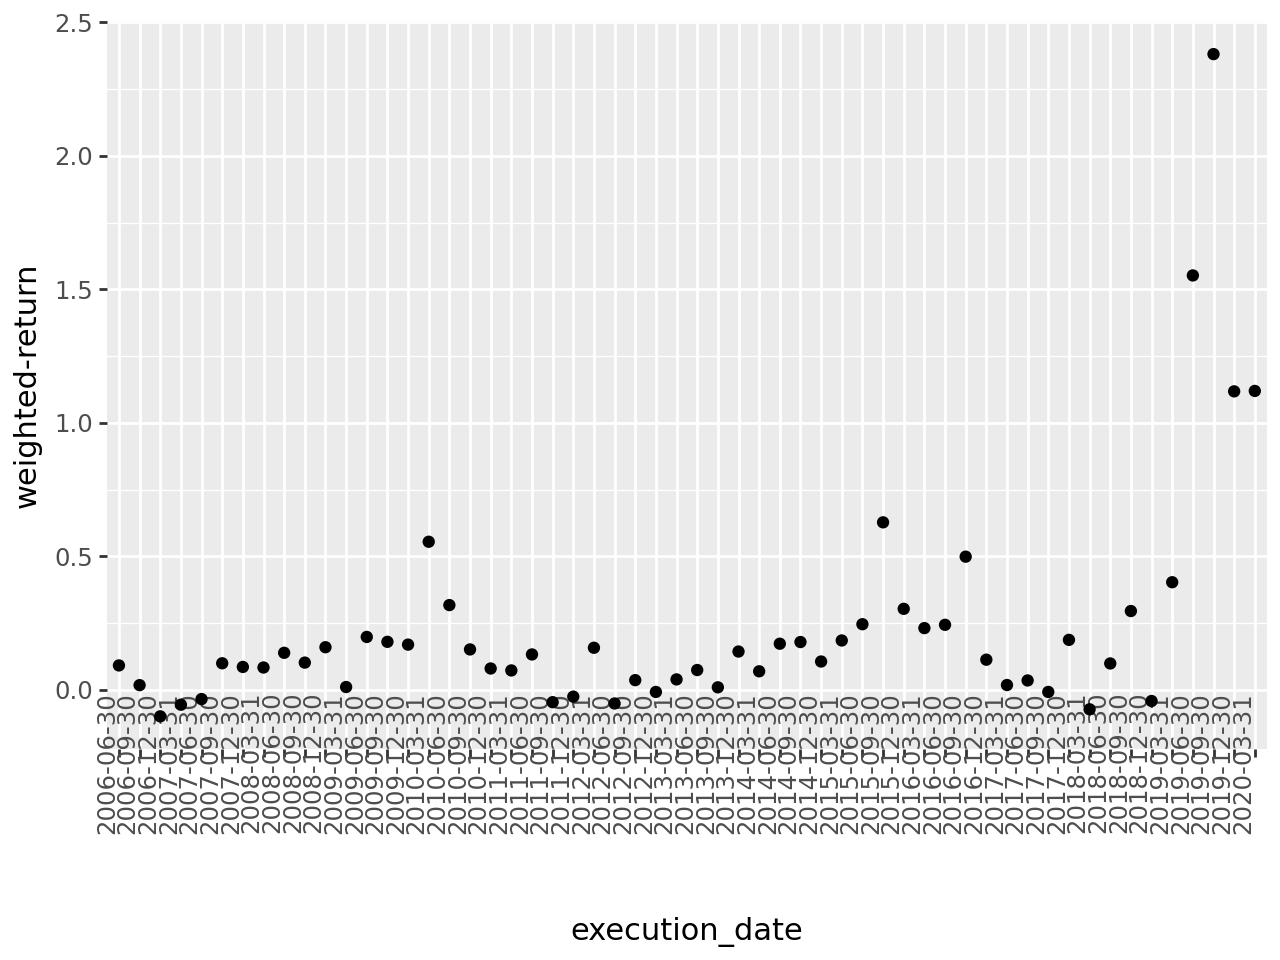

In [677]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



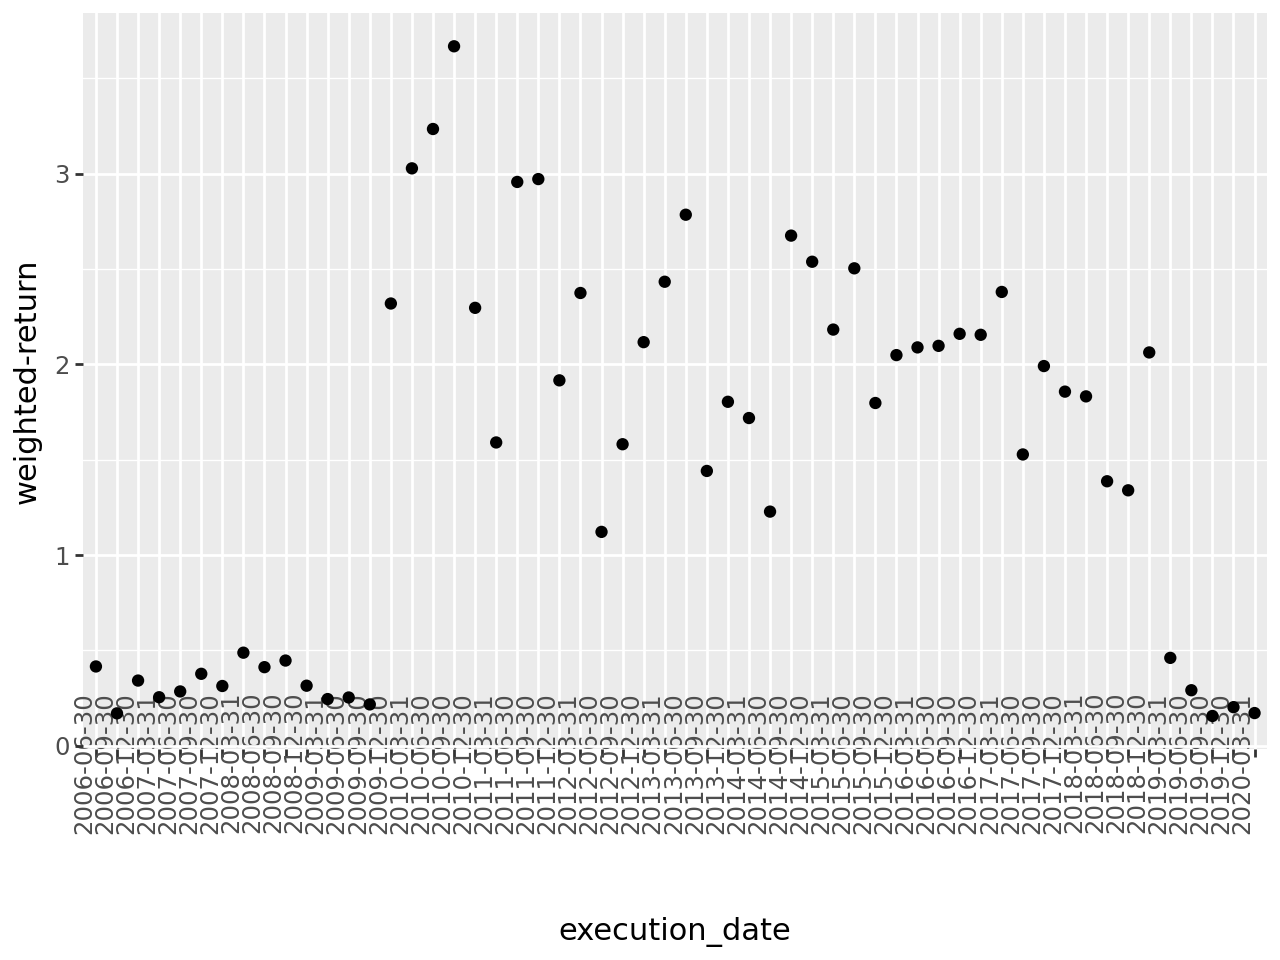

In [678]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

In [411]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

BASELINE

First, we start by defining a baseline to which compare the results of the model. In this case, the baseline is the performance of the best 100 stocks last year.

In [744]:
def get_baseline(test_results_final_tree):
    top100_last_period = data_set[data_set.execution_date == '2020-03-31'].sort_values(by='diff_ch_sp500', ascending=False)[["diff_ch_sp500",'Ticker']].head(500)

    baseline_tickers = data_set[data_set.Ticker.isin(top100_last_period.Ticker)].groupby('execution_date').diff_ch_sp500.mean().reset_index()
    baseline_tickers = baseline_tickers.rename(columns={'diff_ch_sp500': 'diff_ch_sp500_baseline'})
    baseline_tickers.execution_date = baseline_tickers.execution_date.astype('str')
    test_results_final_tree_baseline = pd.merge(test_results_final_tree, baseline_tickers, on = 'execution_date')
    return test_results_final_tree_baseline

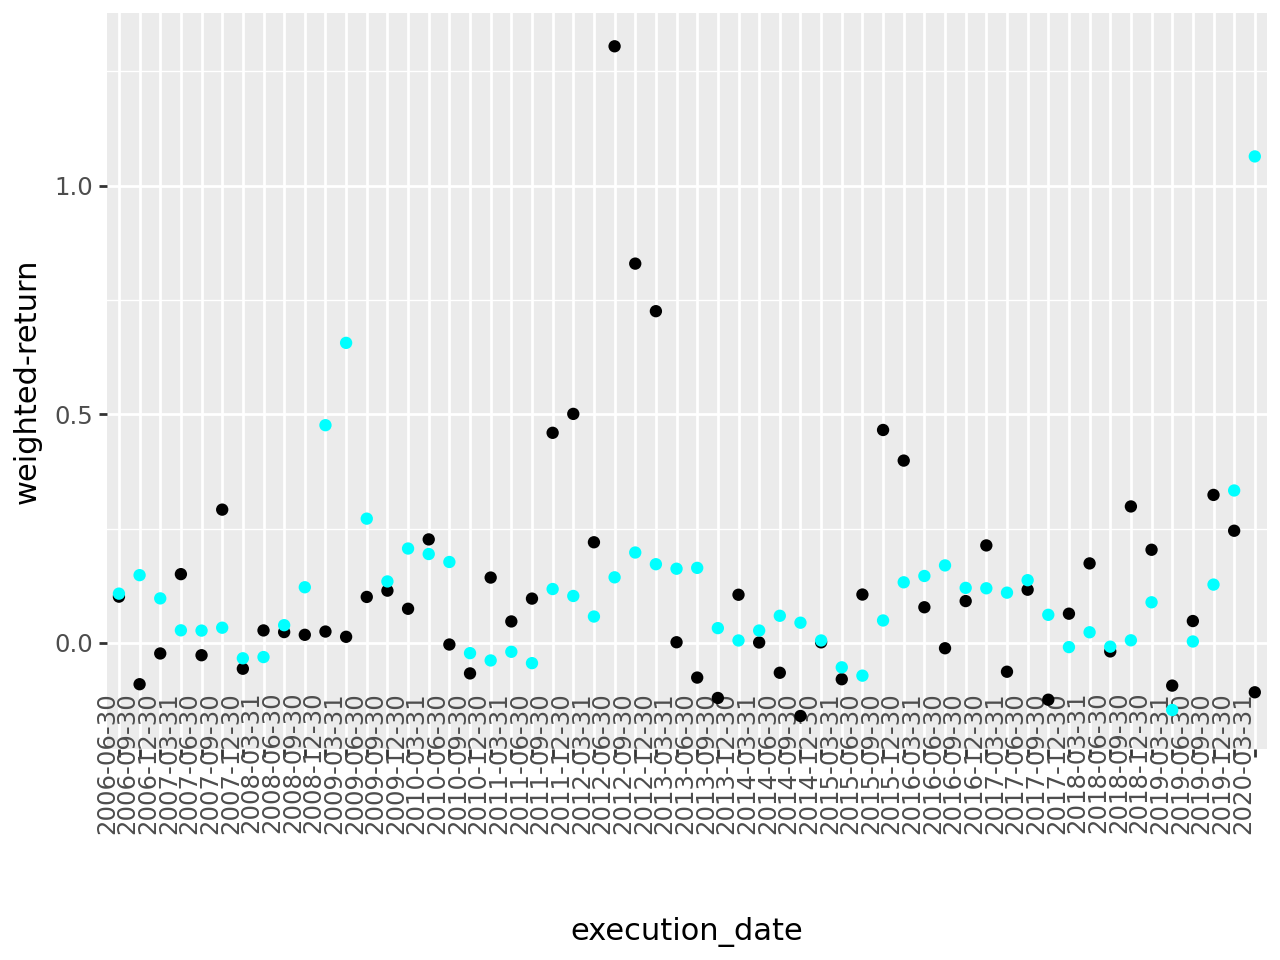

In [745]:
test_results_final_tree_baseline = get_baseline(test_results_final_tree)

ggplot(test_results_final_tree_baseline) + geom_point(aes(x = "execution_date", y = "weighted-return")) + geom_point(aes(x = "execution_date", y = "diff_ch_sp500_baseline"),colour='cyan') + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


OVERFITTING

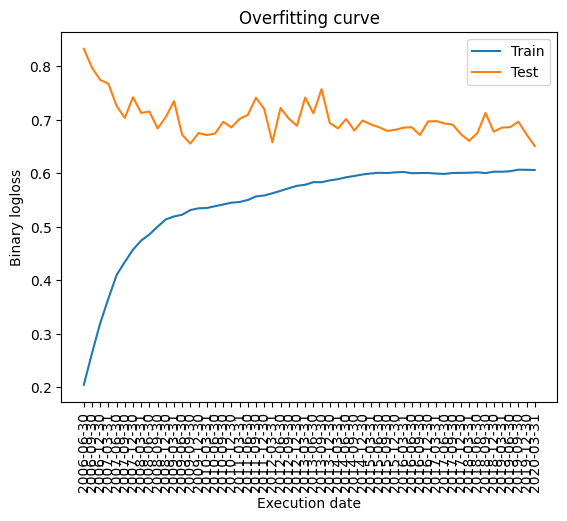

In [698]:
fig, ax = plt.subplots()
ax.plot(train_results_final_tree.execution_date,train_results_final_tree.binary_logloss, label='Train')
ax.plot(test_results_final_tree.execution_date,test_results_final_tree.binary_logloss, label='Test')

ax.set_title('Overfitting curve')
ax.set_xlabel('Execution date')
ax.set_ylabel('Binary logloss')
ax.legend(loc="upper right")
plt.xticks(rotation=90)

plt.show()

As the train set gets larger, train error increases and test error decreases. Still, to see if there is overfitting we need to see the evolution of training and test error through the different training phases.

To confirm the algorithm is actually learning correctly, the learning curves can be plotted. As there are results for every execution date, the learning curves can be represented with a set of boxplots instead of points. To see the progress in learning, these boxplots can be compared to each other by setting the first one to zero and normalizing the rest.

Since the current objective is to diagnose the problems within the model, a low level metric such as binary logloss is chosen, leaving 'weighted return' to present the results in a latter moment.

In [413]:
def learning_curves(set_):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[(date)][set_])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves,learning_curve])


    first_bin_logloss = learning_curves[['binary_logloss','execution_date']].drop_duplicates(['execution_date']).rename(columns={'binary_logloss': 'first_binary_logloss'})
    learning_curves = pd.merge(learning_curves, first_bin_logloss, on= ['execution_date'])
    learning_curves['norm_binary_logloss'] = (learning_curves['binary_logloss'] - learning_curves['first_binary_logloss']) / learning_curves['first_binary_logloss']
    learning_curves = learning_curves.drop(columns='first_binary_logloss')

    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)
    
    return learning_curves

In [699]:
test_lc = learning_curves("valid_0")
train_lc = learning_curves("training")

test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=test_lc['n_trees'].unique())
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=train_lc['n_trees'].unique())

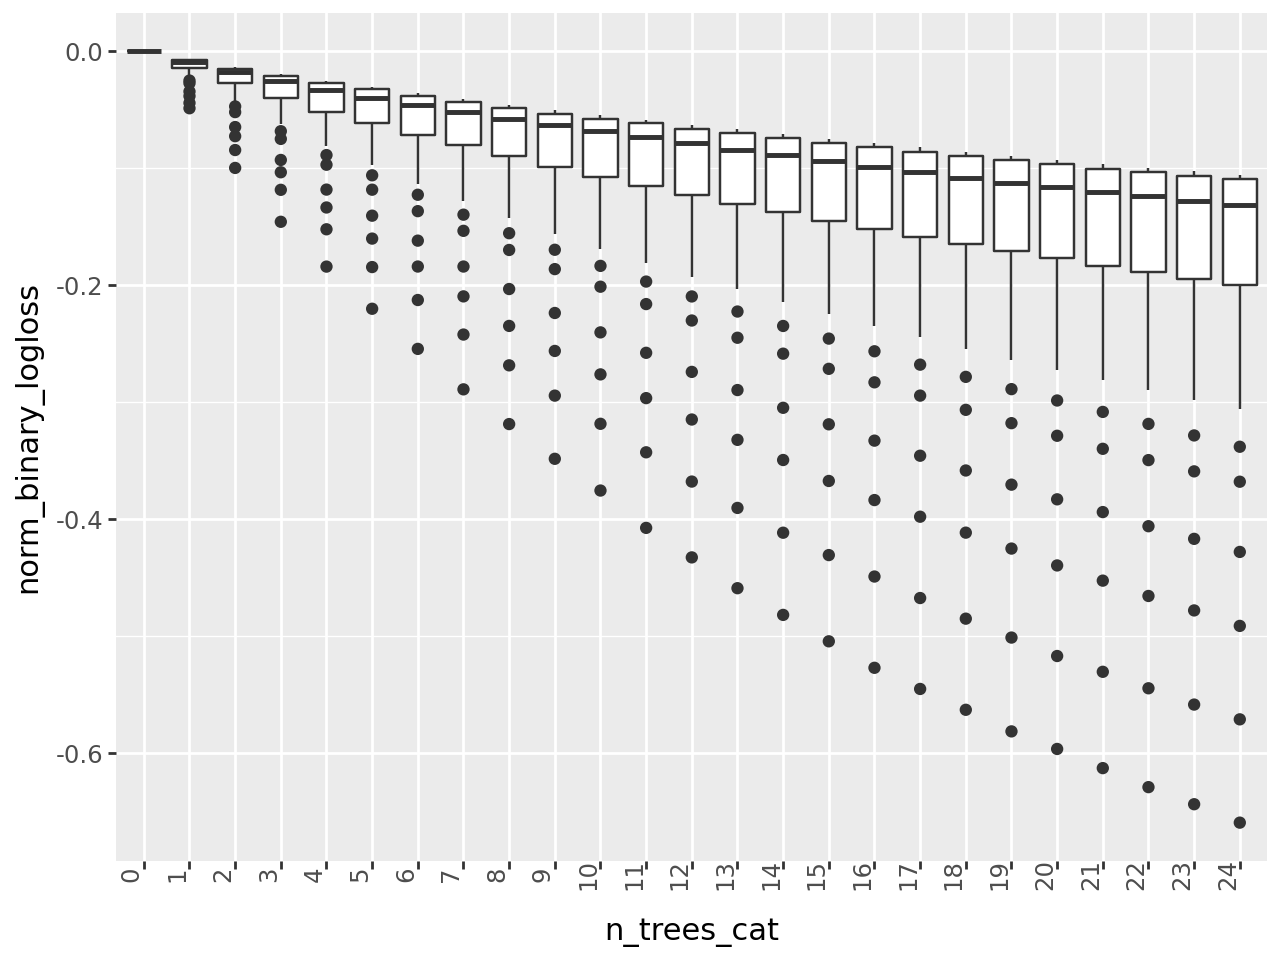

In [700]:
ggplot(train_lc) + geom_boxplot(aes(x = "n_trees_cat", y = "norm_binary_logloss")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


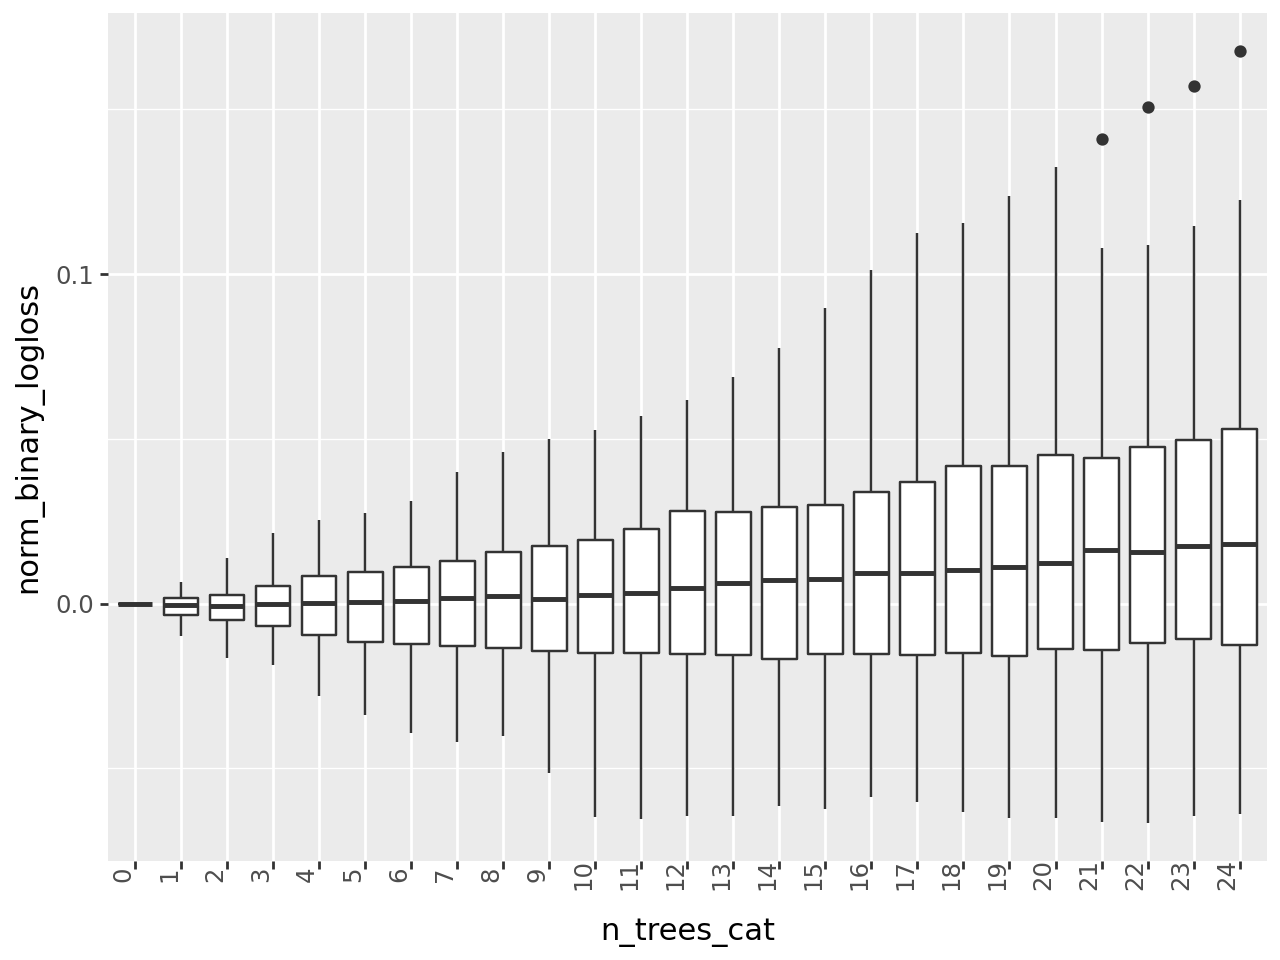

In [701]:
ggplot(test_lc) + geom_boxplot(aes(x = "n_trees_cat", y = "norm_binary_logloss")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


It seems that the model is overfitting since the test error does not decrease like the training error does as the model gets more complex. To try to fix this, the model can be simplified by modifying some parameters like the number of trees and the learning rate.

In [702]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
n_trees = 25
learning_rate = 1e-2

train_all_dates()

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [703]:
test_lc = learning_curves("valid_0")
train_lc = learning_curves("training")

test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=test_lc['n_trees'].unique())
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=train_lc['n_trees'].unique())

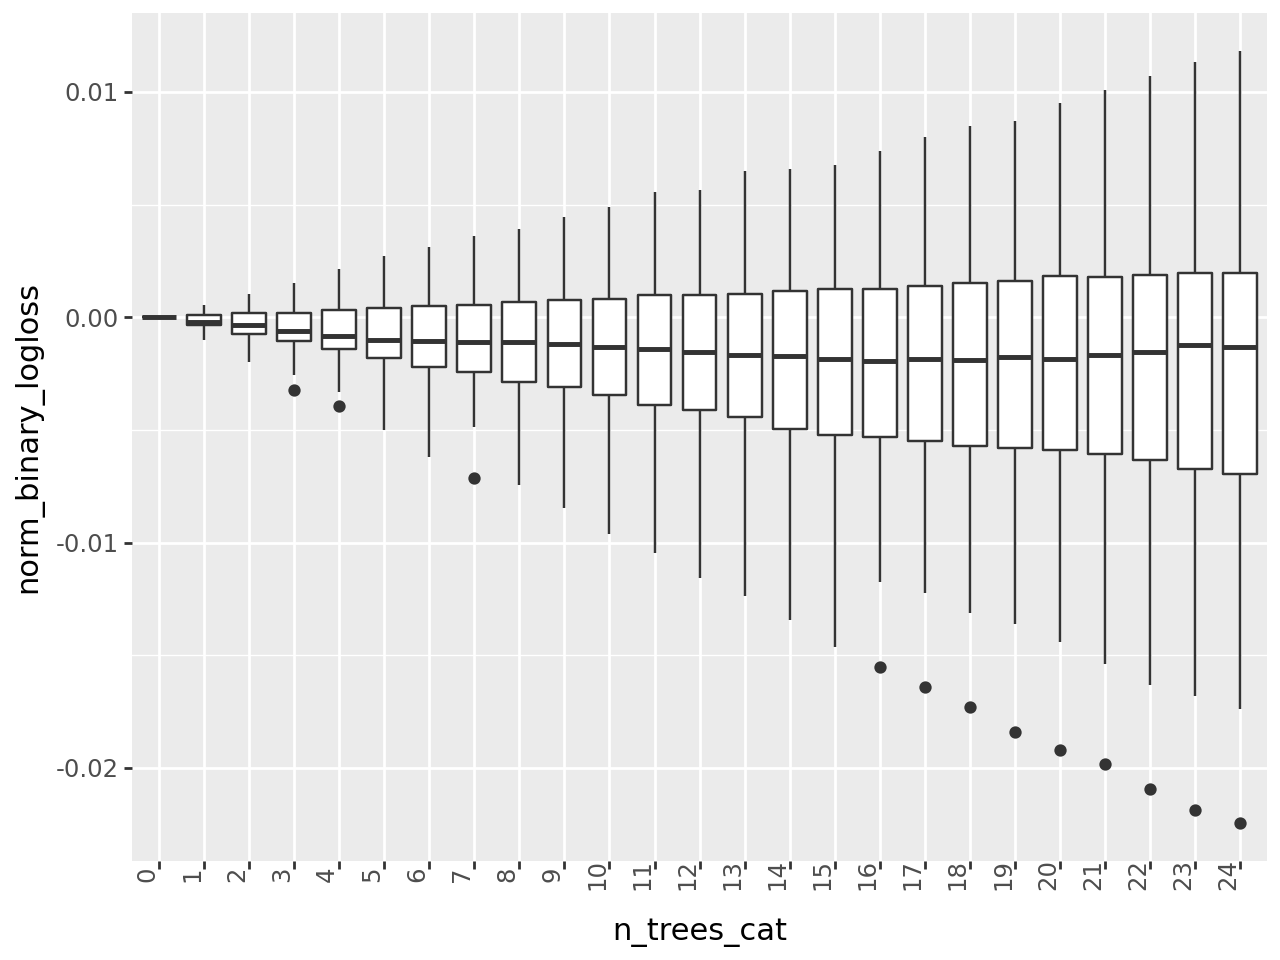

In [704]:
ggplot(test_lc) + geom_boxplot(aes(x = "n_trees_cat", y = "norm_binary_logloss")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


By reducing the learning rate, it appears that the test error decreases, which means the fit is better. The median of the error seems to reach its minimum at 16 trees, at which point it starts to overfit again.

FEATURE IMPORTANCE

Now that we know that the model is learning, we can check if there is some information leakage. To do this, feature importances can be looked at by using SHAP.

In [705]:
compute_importances = True

train_all_dates()

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [570]:
def get_top_features(all_importances):    
    mean_shap_values = []

    for date, shap_values in all_importances.items():
        mean_shap = np.mean(np.abs(shap_values.values), axis=0) 
        mean_shap_values.append(mean_shap)

    mean_shap_df = pd.DataFrame(mean_shap_values, columns=shap_values.feature_names)
    mean_shap_df['date'] = date
    mean_shap_df = mean_shap_df.melt(id_vars='date', var_name='feature', value_name='mean_shap')


    top_features = mean_shap_df.groupby('feature').mean_shap.mean().sort_values(ascending=False).head(10)
    plt.barh(top_features.index, top_features.values)

    plt.show()

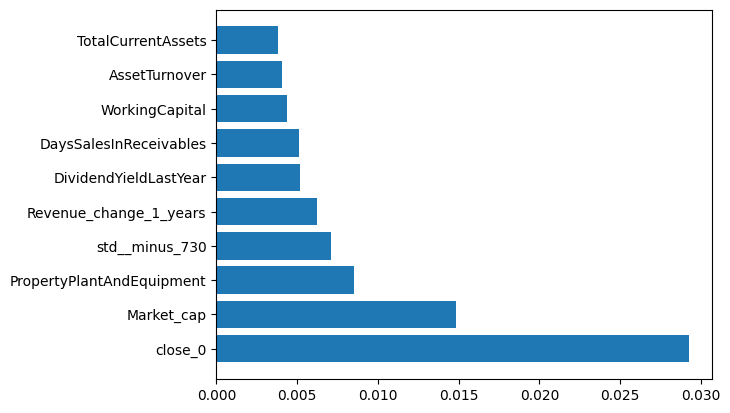

In [706]:
get_top_features(all_importances)

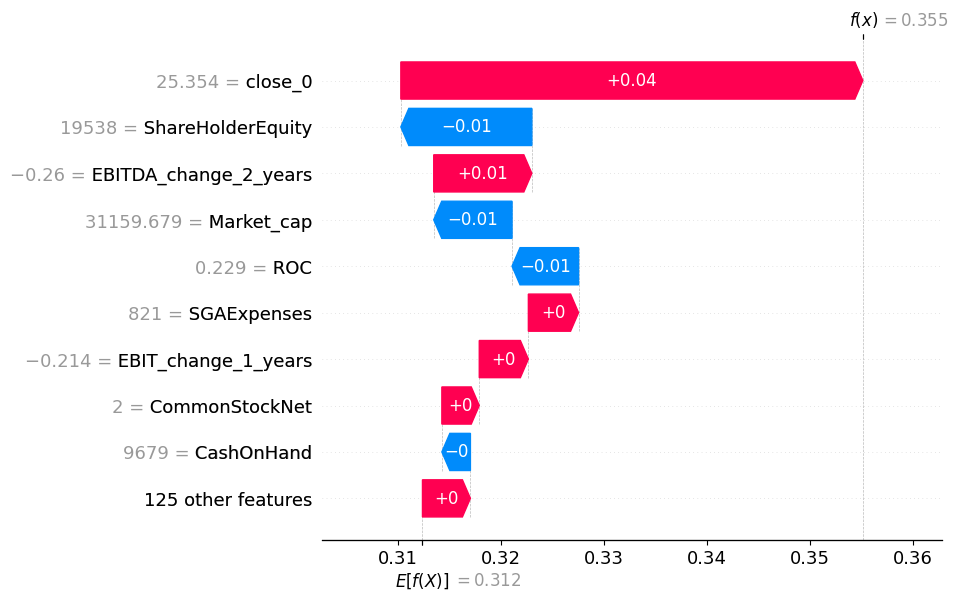

In [707]:
shap.waterfall_plot(all_importances[np.datetime64('2015-06-30T00:00:00.000000000')][0])

There are some features with a lot of relevance that seem suspicious. For example, "close_0" has an extremely big impact on predictions compared to other features. When looking into it, it results that close_0 leaks information from the future, as the closing price in the data for tickers with counter-splitted stocks was calculated using the current price as a factor. 

Also, it is important to note that some "change" features have a lot of importance. These features indicate future variations in the data, which means they also leak information. Considering this, it is best to retrain the model after removing that kind of features.

In [708]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
    
    change_cols = [
                        'close_0'
                        'sp500_change_730', 
                        'FreeCashFlowPerShare_change_1_years', 
                        'FreeCashFlowPerShare_change_2_years', 
                        'OperatingCashFlowPerShare_change_1_years', 
                        'OperatingCashFlowPerShare_change_2_years', 
                        'EBITDA_change_1_years', 
                        'EBITDA_change_2_years', 
                        'EBIT_change_1_years', 'EBIT_change_2_years', 
                        'Revenue_change_1_years', 
                        'Revenue_change_2_years', 
                        'NetCashFlow_change_1_years', 
                        'NetCashFlow_change_2_years', 
                        'CurrentRatio_change_1_years', 
                        'CurrentRatio_change_2_years']
    
    columns_to_remove = columns_to_remove + change_cols + technical_features
        
    return columns_to_remove

In [709]:
train_all_dates()

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [710]:
test_lc = learning_curves("valid_0")
train_lc = learning_curves("training")

test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=test_lc['n_trees'].unique())
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=train_lc['n_trees'].unique())

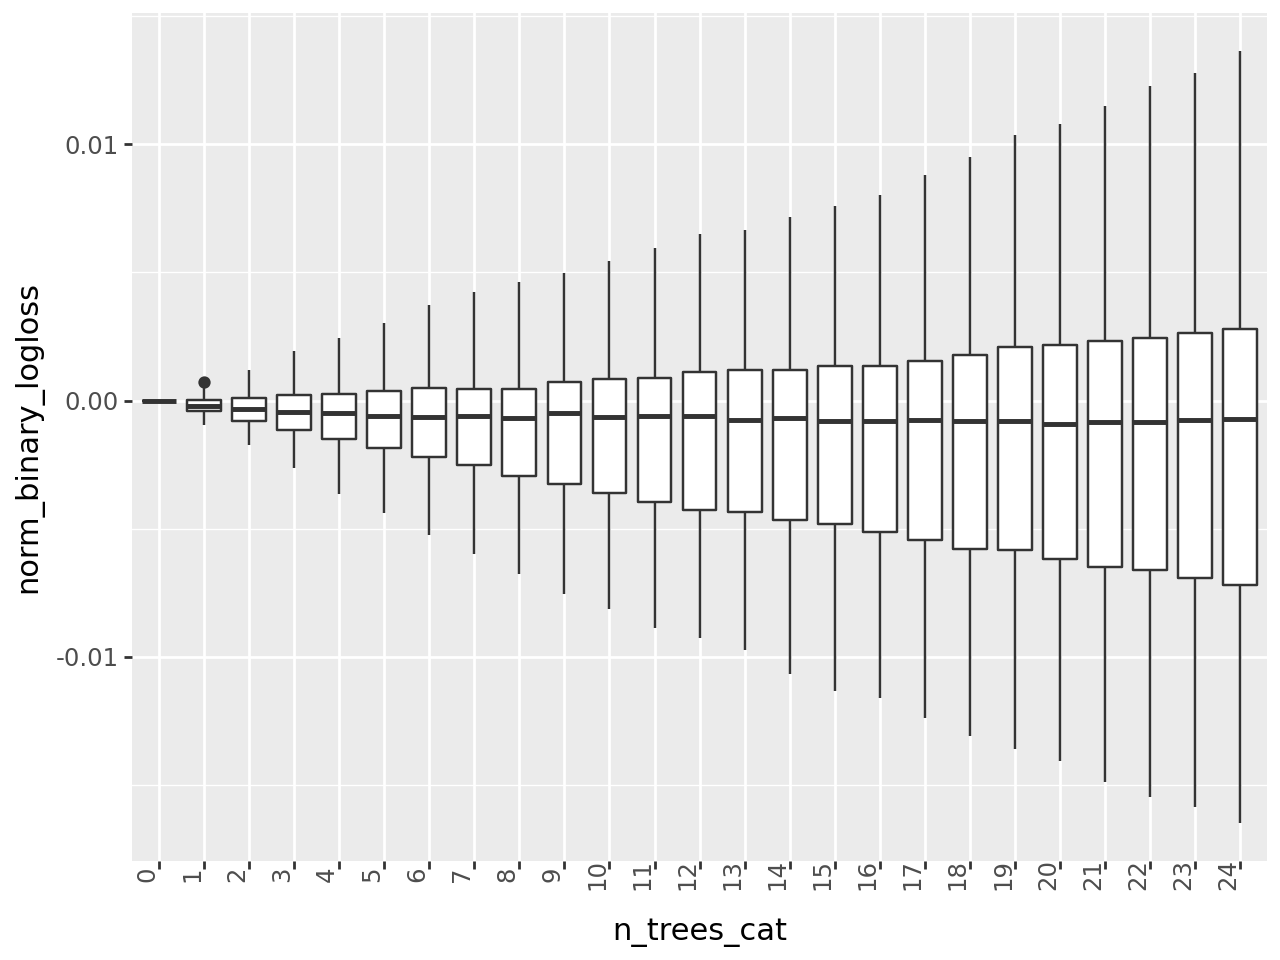

In [711]:
ggplot(test_lc) + geom_boxplot(aes(x = "n_trees_cat", y = "norm_binary_logloss")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


As expected, model performance decreases notably. This is due to the fact that information from the future is no longer affecting predictions.

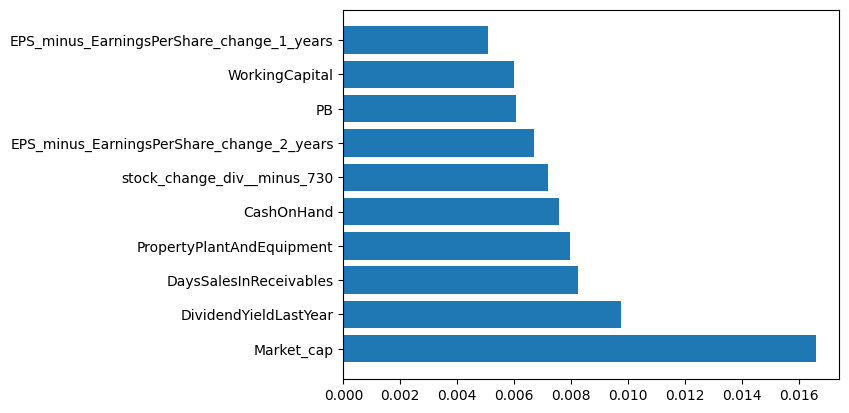

In [717]:
get_top_features(all_importances)

The features' importance is now more balanced.

RESULTS

In [712]:
test_results = parse_results_into_df("valid_0")
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


In [746]:
test_results_final_tree_baseline['diff_ch_sp500_baseline'].median()

0.09319979532125669

In [747]:
test_results_final_tree_baseline['diff_ch_sp500_baseline'].mean()

0.11120698063715416

In [748]:
test_results_final_tree['weighted-return'].median()

0.06938536742433922

In [749]:
test_results_final_tree['weighted-return'].mean()

0.1293868953099023

The median return of the model is worse than that of the baseline while the mean is better. This means that on most periods the baseline performs better than the model, but on a few periods the model has an extraordinarily good performance that makes the mean go up.

**TAKEAWAYS**

- Dataset is slightly reduced to show only top tickers in terms of marketcap in order to make the training faster.
- A baseline is made to compare the results of the model. It consists of the top 500 stocks with best performance in the last period.
- Learning curves are plotted to see if there is overfitting. At first, it results there is some, which is solved cutting the complexity of the model by reducing the learning rate.
- Feature importance is plotted using SHAP to ensure there is no information leakage. It resulted that some features were doing so, so they were removed.
- Model is re-trained after all this changes finally comparing the results with the baseline.